### Experiments with training spectral bias

Imports

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [3]:
save = False

Only for python script: uncomment if running on cluster

In [4]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [5]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [77]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

Base dataset class

In [8]:
class BaseFourierDataset(Dataset):
    def __init__(self, num_samples, num_points, max_freq):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_freq = max_freq
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives = self.generate_data()

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + n_terms] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Can exclude the first element with the large derivative using [1:]
        # return torch.FloatTensor(self.functions[idx][1:]), torch.FloatTensor(self.first_derivatives[idx][1:])
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx])

    def generate_data(self):
        raise NotImplementedError("Subclasses must implement generate_data method")

In [9]:
class LowFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=5):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

class HighFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, min_freq=15, max_freq=20):
        self.min_freq = min_freq
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            high_freq_coeffs = torch.complex(torch.randn(self.max_freq-self.min_freq+1), 
                                            torch.randn(self.max_freq-self.min_freq+1))
            c[self.max_freq+self.min_freq:] = high_freq_coeffs
            c[:self.max_freq-self.min_freq+1] = torch.conj(high_freq_coeffs.flip(0))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

            functions.append(y.detach().numpy())
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)


In [10]:
class GeneralFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=random.randrange(20)):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

Uncomment the below to generate the datasets for the first time. After saving the datasets, they can be loaded in for future use.

In [11]:
num_samples = 500
num_points = 1000

# general_freq_dataset = GeneralFrequencyFourierDataset(num_samples, num_points)
# low_freq_dataset = LowFrequencyFourierDataset(num_samples, num_points, max_freq=5)
# high_freq_dataset = HighFrequencyFourierDataset(num_samples, num_points, min_freq=20, max_freq=30)

# # Create DataLoaders
# batch_size = 32
# general_dataloader = DataLoader(general_freq_dataset, batch_size=batch_size, shuffle=True)
# low_freq_dataloader = DataLoader(low_freq_dataset, batch_size=batch_size, shuffle=True)
# high_freq_dataloader = DataLoader(high_freq_dataset, batch_size=batch_size, shuffle=True)

# # Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

General frequency dataset

In [12]:
dataset_g = torch.load('../../datasets/general_freq_dataset.pt')
total_size = len(dataset_g)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_g, test_dataset_g = random_split(dataset_g, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

Low frequency dataset

In [13]:
dataset_l = torch.load('../../datasets/low_freq_dataset.pt')
total_size = len(dataset_l)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_l, test_dataset_l = random_split(dataset_l, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

High frequency dataset

In [14]:
dataset_h = torch.load('../../datasets/high_freq_dataset.pt')
total_size = len(dataset_h)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_h, test_dataset_h = random_split(dataset_h, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)

## Plot a function

Low freq function

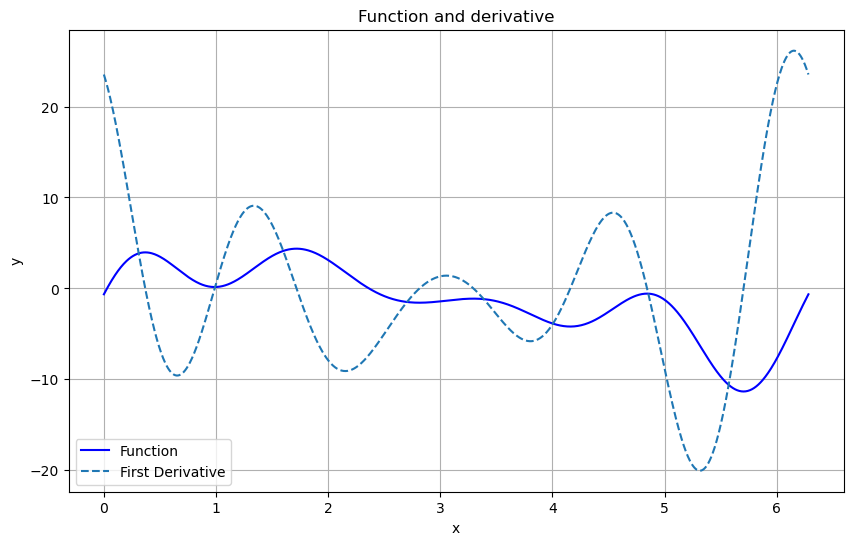

In [15]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    
    plt.title('Function and derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(dataset=train_dataset_l, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

General freq function

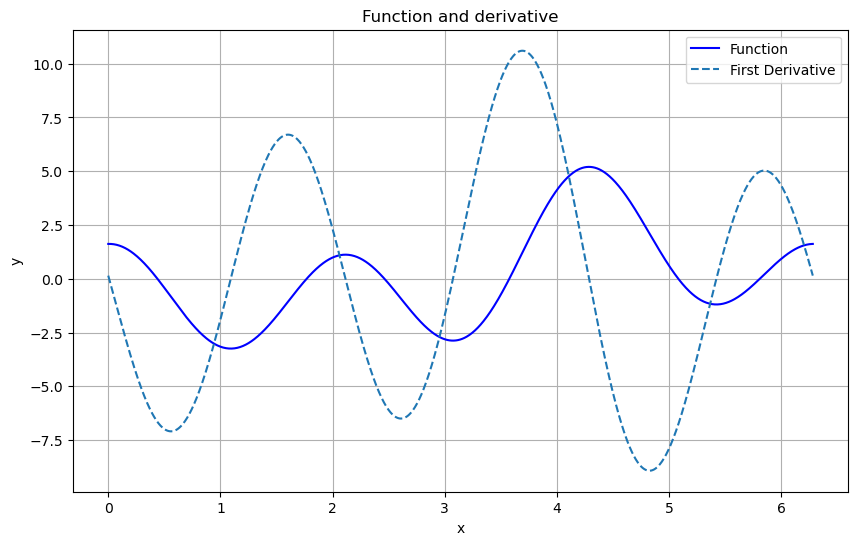

In [16]:
train_dataloader_viz = get_random_function(dataset=train_dataset_g, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

High freq function

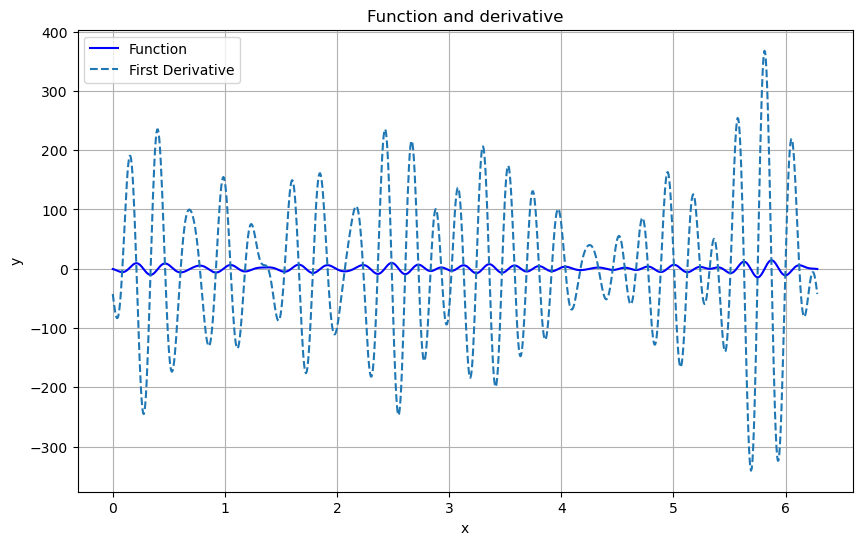

In [17]:
train_dataloader_viz = get_random_function(dataset=train_dataset_h, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [18]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [19]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

To use the previously trained model, uncomment below

In [20]:
# f0.load_state_dict(torch.load('models/f0_E1000_standardized.pth'))

## Miscellaneous plotting functions

In [21]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [22]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

## Plot results

Low frequency output

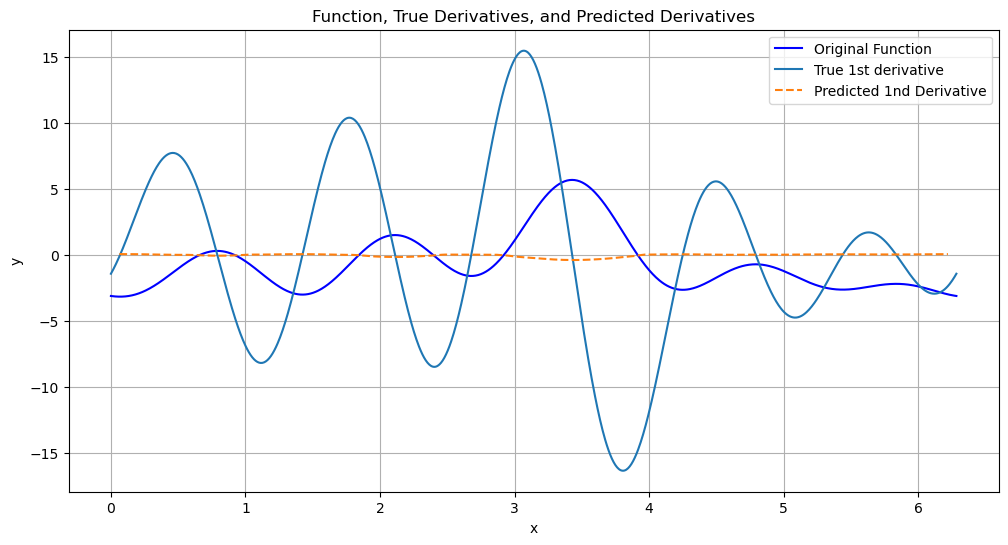

In [23]:
plot_output(f0, dataset=train_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

General frequency output

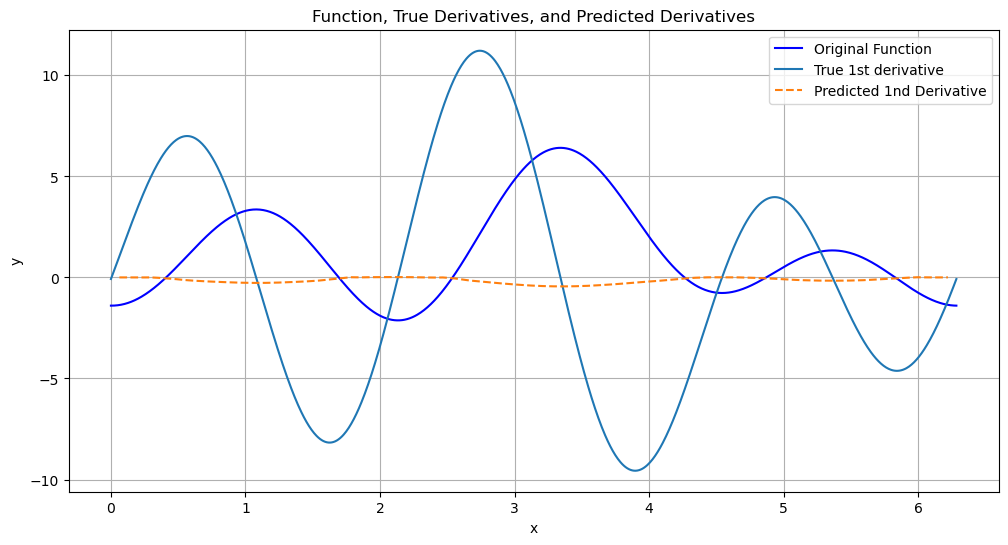

In [24]:
plot_output(f0, dataset=train_dataset_g, order=1, save_dir='..plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_gf_output', save=save)

High frequency output

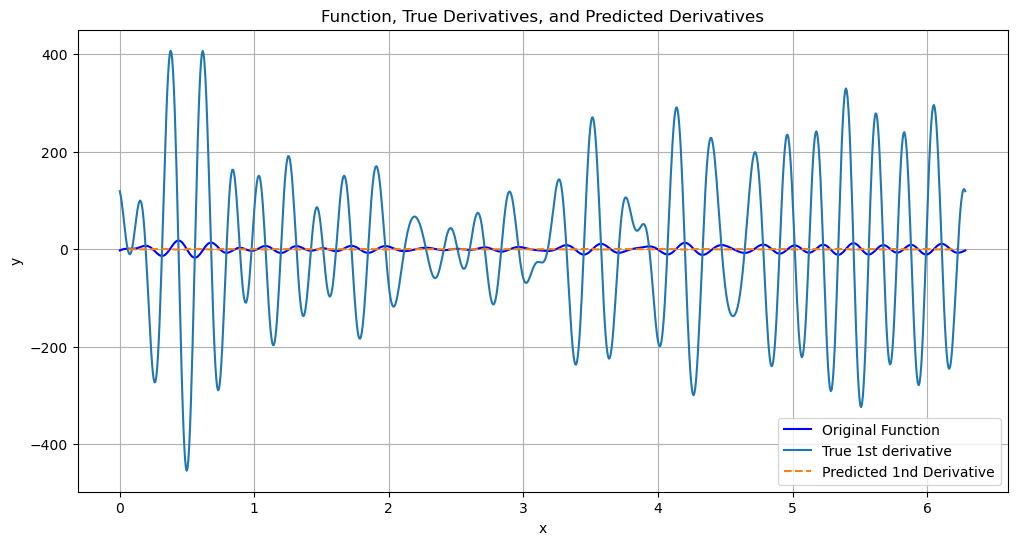

In [25]:
plot_output(f0, dataset=train_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_hf_output', save=save)

## Metrics (MSE and NMSE)

In [26]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

Loss over low frequency functions

**Note: the values displayed directly below don't mean anything because they're using an untrained model**

In [27]:
print(f"MSE over low freq train functions: {compute_mse(train_dataloader_l, f0)[0]}")
print(f"NMSE over low freq train functions: {compute_mse(train_dataloader_l, f0)[1]}\n")

print(f"MSE over low freq test functions: {compute_mse(test_dataloader_l, f0)[0]}")
print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, f0)[1]}")


MSE over low freq train functions: 112.37535095214844
NMSE over low freq train functions: 1.0002650022506714

MSE over low freq test functions: 117.25035095214844
NMSE over low freq test functions: 1.000205159187317


Loss over general frequency functions

In [28]:
print(f"MSE over general freq train functions: {compute_mse(train_dataloader_g, f0)[0]}")
print(f"NMSE over general freq train functions: {compute_mse(train_dataloader_g, f0)[1]}\n")

print(f"MSE over general freq test functions: {compute_mse(test_dataloader_g, f0)[0]}")
print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, f0)[1]}\n")

MSE over general freq train functions: 27.255739212036133
NMSE over general freq train functions: 1.0007922649383545

MSE over general freq test functions: 27.178239822387695
NMSE over general freq test functions: 1.0007846355438232



Loss over high frequency functions

In [29]:
print(f"MSE over high freq train functions: {compute_mse(train_dataloader_h, f0)[0]}")
print(f"NMSE over high freq train functions: {compute_mse(train_dataloader_h, f0)[1]}\n")

print(f"MSE over high freq test functions: {compute_mse(test_dataloader_h, f0)[0]}")
print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, f0)[1]}\n")

MSE over high freq train functions: 28146.224609375
NMSE over high freq train functions: 0.9999207854270935

MSE over high freq test functions: 27007.658203125
NMSE over high freq test functions: 0.9999188184738159



Function that includes all these print statements

In [30]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

### Model training

In [31]:
model_3L_K3 = SimpleCNN()

In [32]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

In [33]:
# train_losses, test_losses = model_training(model_3L_K3, train_dataloader_g, test_dataloader_g,\
#     num_epochs=5000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# torch.save(f0.state_dict(), f'../../models/{model_name}_E{num_epochs}_phased_training.pth')

In [34]:
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Plot results using trained models

3-layer conv

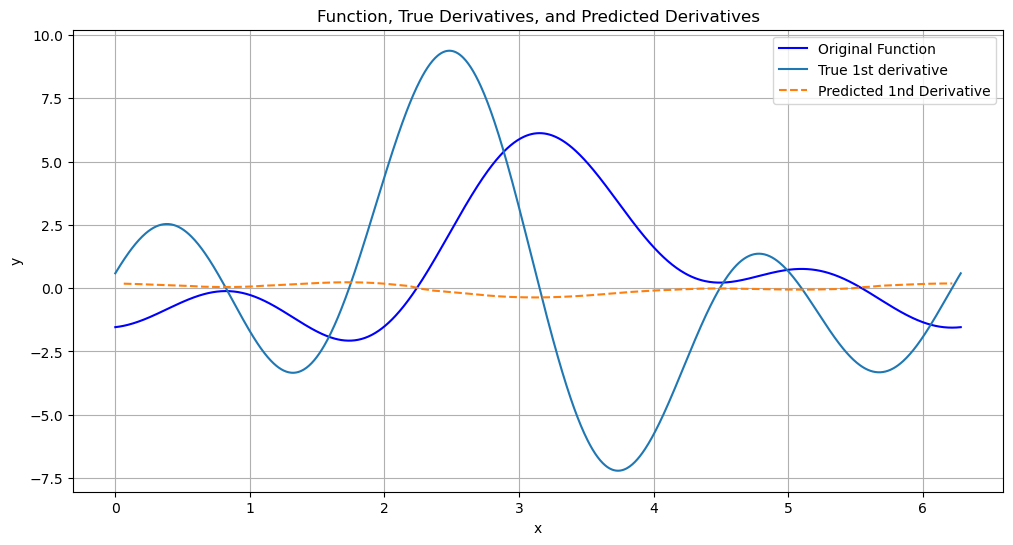

In [35]:
plot_output(model_3L_K3, dataset=train_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_gf_output', save=save)

## Training CNN with one layer

**This CNN class has kernel size 3**

In [36]:
class OneLayerK3CNN(nn.Module):
    def __init__(self):
        super(OneLayerK3CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        return x

In [37]:
model_1L_K3 = OneLayerK3CNN()
for param in model_1L_K3.parameters():
  print(param.data)

epsilon = 2*torch.pi / 1000
model_1L_K3.conv1.weight.data = torch.tensor([[[-1/(2*epsilon), 0., 1/(2*epsilon)]]])
for param in model_1L_K3.parameters():
  print(param.data)

tensor([[[0.4455, 0.0323, 0.5211]]])
tensor([[[-79.5775,   0.0000,  79.5775]]])


In [38]:
# train_losses, test_losses = model_training(model_1L_K3, train_dataloader_g, test_dataloader_g,\
#     num_epochs=10000, split_freq=10, filename='../plots/spectral_bias/f0_E1000_one_layer',\
#         order='first')

In [39]:
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias',\
    filename='f0_E10000_one_layer', save=save)

In [40]:
for param in model_1L_K3.parameters():
  print(param.data)

tensor([[[-79.5775,   0.0000,  79.5775]]])


In [41]:
# train_losses, test_losses = model_training(model_1L_K3, train_dataloader_g, test_dataloader_g,\
#     num_epochs=10000, split_freq=10, filename='../plots/spectral_bias/f0_E1000_one_layer',\
#         order='first')

## Testing with sin(x)

**CNN class with kernel size 2**

In [42]:
class OneLayerK2CNN(nn.Module):
    def __init__(self):
        super(OneLayerK2CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=2, padding=0, bias=False)
    
    def forward(self, x):
        x = F.pad(x, (1, 0), mode='circular')  # Use circular padding
        return self.conv1(x)

In [43]:
model_1L_K2 = OneLayerK2CNN()

In [44]:
# epsilon = 2*torch.pi / 1000
# weights = torch.tensor([[-1/epsilon, 1/epsilon]]).reshape(1, 1, 2)
# model_1L_K2.conv1.weight.data = weights

In [45]:
xs = torch.linspace(0, 2*torch.pi, 1000)
ys = torch.sin(xs)
ys_cos = torch.cos(xs)
ys = ys.view(1,1,-1)
with torch.no_grad():
    output = model_1L_K2(ys).squeeze()

In [46]:
output.shape

torch.Size([1000])

In [47]:
criterion = torch.nn.MSELoss()
loss = criterion(output[1:], ys_cos[1:])
loss2 = loss / torch.mean(ys_cos[1:] ** 2)
print(f"NMSE: {loss2} and MSE: {loss}")

NMSE: 1.3345811367034912 and MSE: 0.6672905683517456


In [48]:
for param in model_1L_K2.parameters():
  print(param.data)

tensor([[[-0.0060, -0.5724]]])


In [49]:
# train_losses, test_losses = model_training(model_1L_K2, train_dataloader_g, test_dataloader_g,\
#     num_epochs=50000, split_freq=10, filename='../plots/spectral_bias/f0_E1000_one_layer_kernel_2',\
#         order='first')

In [50]:
l, g, h = print_and_store_metrics(model_1L_K2)
l, g, h

(1.0338122844696045, 1.0859540700912476, 1.0004537105560303)

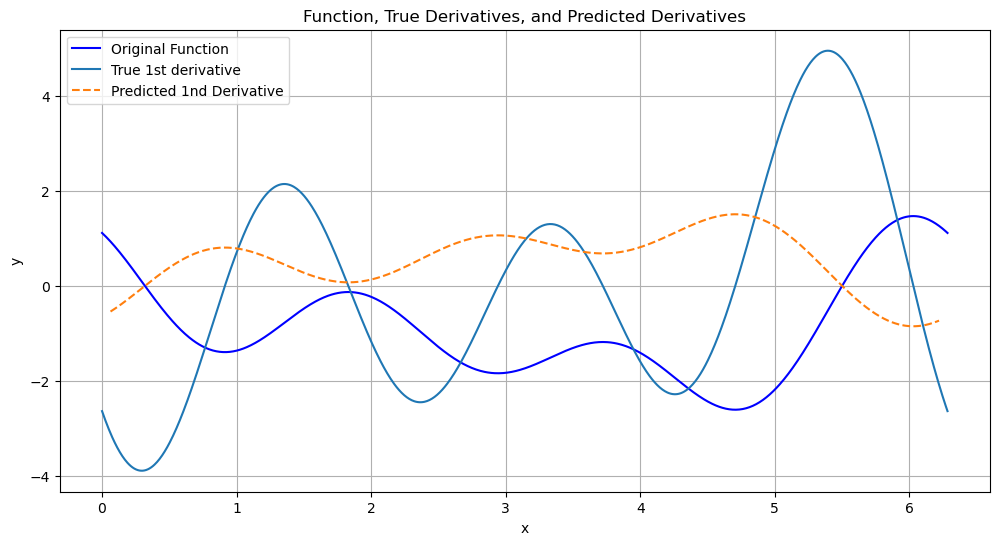

In [51]:
plot_output(model_1L_K2, dataset=train_dataset_g, order=1,\
    save_dir='../plots/spectral_bias',\
        filename=f'{model_name}_E{num_epochs}_1L_K2_output', save=save)

## Trying to create the colormap

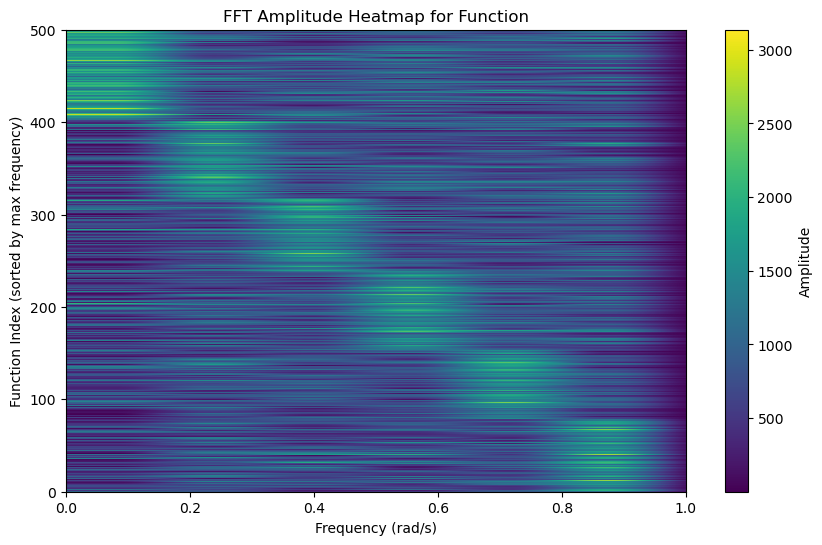

In [52]:
def compute_fft_and_max_freq(functions):
    fft_amplitudes = []
    max_frequencies = []
    n = functions.shape[1]
    freqs = np.fft.fftfreq(n, d=(2*np.pi/n))
    # freqs = freqs * (num_points / (2*np.pi))

    for function in functions:
        fft_vals = np.fft.fft(function)
        amplitudes = np.abs(fft_vals[:n//2])  # Taking only the positive frequencies
        fft_amplitudes.append(amplitudes)
        
        # Maximum frequency based on the highest amplitude
        max_freq = freqs[np.argmax(amplitudes)]
        max_frequencies.append(max_freq)
    
    return np.array(fft_amplitudes), np.array(max_frequencies), freqs[:n//2]

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xlim=1):
    # Sort functions by the maximum frequency
    sorted_indices = np.argsort(max_frequencies)
    sorted_fft = fft_amplitudes[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)])
    plt.colorbar(label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim(0, xlim)
    plt.show()

def plot_heatmap2(fft_amplitudes, max_frequencies, freqs, fun_type):
    # Convert frequencies to the original scale
    freqs_original = freqs * (2*np.pi)
    
    # Sort functions by the maximum frequency
    sorted_indices = np.argsort(max_frequencies)
    sorted_fft = fft_amplitudes[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.imshow(sorted_fft, aspect='auto', extent=[freqs_original[0], freqs_original[-1], 0, len(sorted_fft)])
    plt.colorbar(label='Amplitude')
    plt.xlabel('Frequency')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim(0, 50)  # Limit to the maximum frequency used in generation
    plt.show()


# Example Usage
num_samples = 500
num_points = 1000
low_freq_dataset = LowFrequencyFourierDataset(num_samples, num_points, max_freq=5)
functions, derivatives = low_freq_dataset.generate_data()  # Assuming generate_data() returns numpy arrays

fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(functions)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Function')


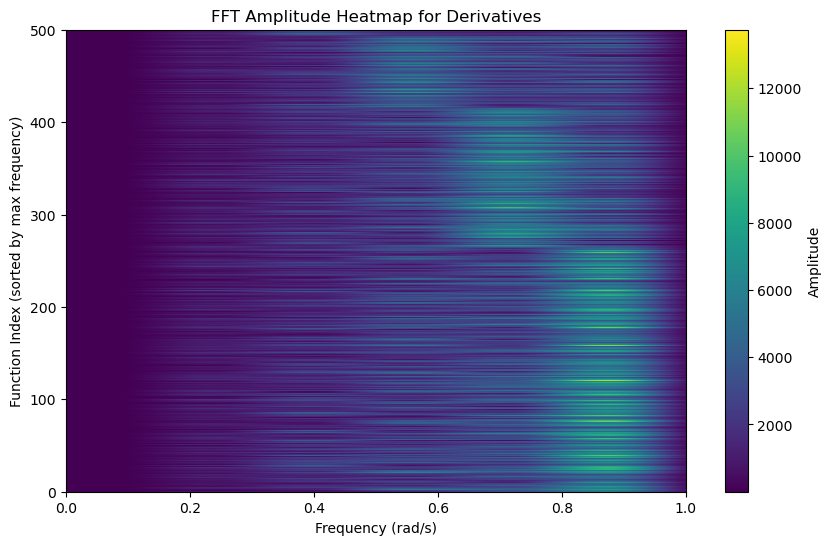

In [53]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(derivatives)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Derivatives')

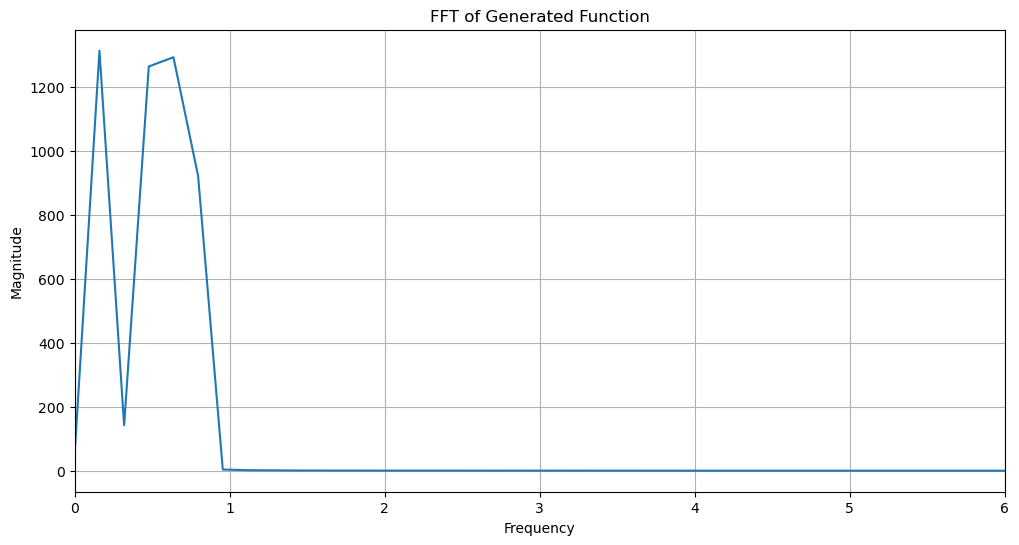

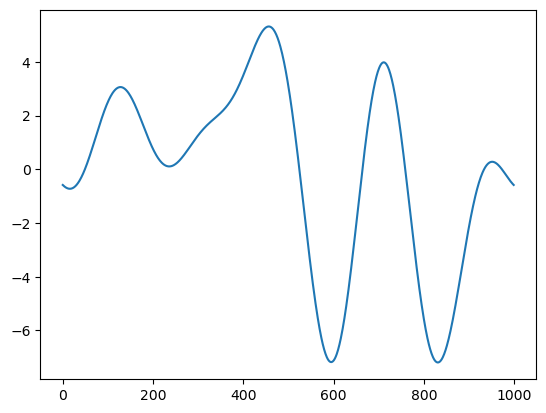

In [54]:
test_fun = low_freq_dataset[0]
# Assuming 'functions' is your array of generated functions
function = test_fun[0]  # Take the first function as an example

# Perform FFT
fft_result = np.fft.fft(function)
fft_freq = np.fft.fftfreq(len(function), 2*np.pi/len(function))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(fft_freq[:len(function)//2], np.abs(fft_result)[:len(function)//2])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('FFT of Generated Function')
plt.xlim(0, 6)  # Focus on the relevant frequency range
plt.grid(True)
plt.show()

plt.plot(function)
plt.show()


### High freq plots

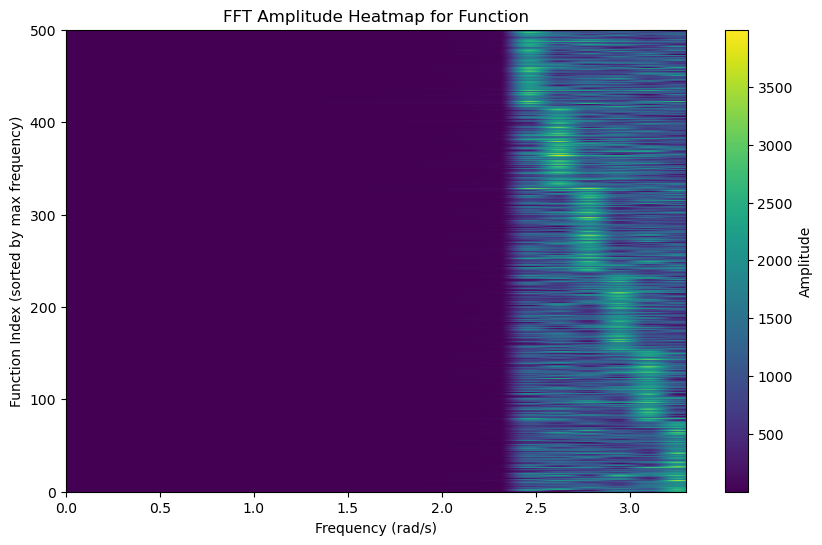

In [55]:
high_freq_dataset = HighFrequencyFourierDataset(num_samples, num_points)
functions, derivatives = high_freq_dataset.generate_data()  # Assuming generate_data() returns numpy arrays

fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(functions)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Function', xlim=3.3)


**Compute frequencies of model outputs**

In [56]:
def compute_fft_and_max_freq_model(model, dataloader):
    fft_amplitudes = []
    max_frequencies = []

    model.eval()
    with torch.no_grad():
        for function_batch, _ in dataloader:  # Assuming the second item is not used
            function_batch = function_batch.unsqueeze(1)  # Add channel dimension if necessary

            # Forward pass
            output_batch = model(function_batch)
            
            # convert to numpy for FFT 
            output_batch = output_batch.squeeze().cpu().numpy()
            
            # Calculate frequency array from the first batch's output
            n = output_batch.shape[-1]
            freqs = np.fft.fftfreq(n, d=(2*np.pi/n))[:n//2]
            
            fft_vals = np.fft.fft(output_batch, axis=1)
            amplitudes = np.abs(fft_vals[:,:n//2])

            fft_amplitudes.extend(amplitudes)
            
            max_indices = np.argmax(amplitudes, axis=1)
            max_frequencies.extend(freqs[max_indices])

    return np.array(fft_amplitudes), np.array(max_frequencies), freqs

functions = LowFrequencyFourierDataset(num_samples=500, num_points=1000, max_freq=5)
dataloader = DataLoader(functions, batch_size=32, shuffle=False)

### Compute frequencies of model outputs

In [57]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq_model(model_3L_K3, dataloader)

In [58]:
print(compute_mse(train_dataloader_l, model_3L_K3)[0])

111.74185180664062


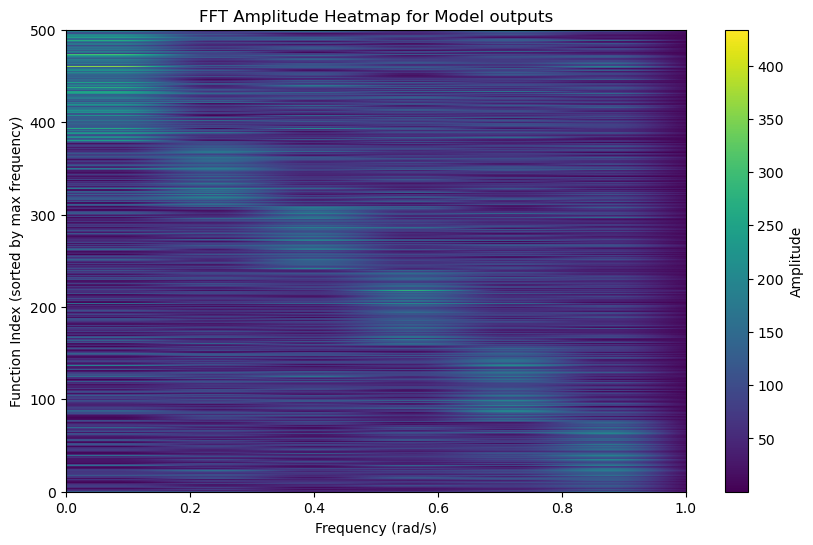

In [59]:
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Model outputs')

## Updated CNN class

In [60]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs):
                x = self.relu(conv(x))
            else:
                x = self.conv(x)
        return x

**For kernel size 3**

Epoch [1/1000], Train Loss: 26.9478, Test Loss: 27.0498
Epoch [2/1000], Train Loss: 26.8565, Test Loss: 26.7440
Epoch [3/1000], Train Loss: 26.3218, Test Loss: 26.3120
Epoch [4/1000], Train Loss: 25.9230, Test Loss: 25.7433
Epoch [5/1000], Train Loss: 25.5234, Test Loss: 25.0668
Epoch [6/1000], Train Loss: 24.7120, Test Loss: 24.2493
Epoch [7/1000], Train Loss: 24.0427, Test Loss: 23.4883
Epoch [8/1000], Train Loss: 23.2584, Test Loss: 22.7415
Epoch [9/1000], Train Loss: 22.3002, Test Loss: 21.9873
Epoch [10/1000], Train Loss: 21.9738, Test Loss: 21.4301
Epoch [11/1000], Train Loss: 21.0143, Test Loss: 20.7216
Epoch [12/1000], Train Loss: 20.7578, Test Loss: 20.3753
Epoch [13/1000], Train Loss: 20.1835, Test Loss: 19.9262
Epoch [14/1000], Train Loss: 19.5641, Test Loss: 19.3955
Epoch [15/1000], Train Loss: 19.3175, Test Loss: 18.8810
Epoch [16/1000], Train Loss: 18.8936, Test Loss: 18.5082
Epoch [17/1000], Train Loss: 18.4968, Test Loss: 18.1235
Epoch [18/1000], Train Loss: 18.3050, Te

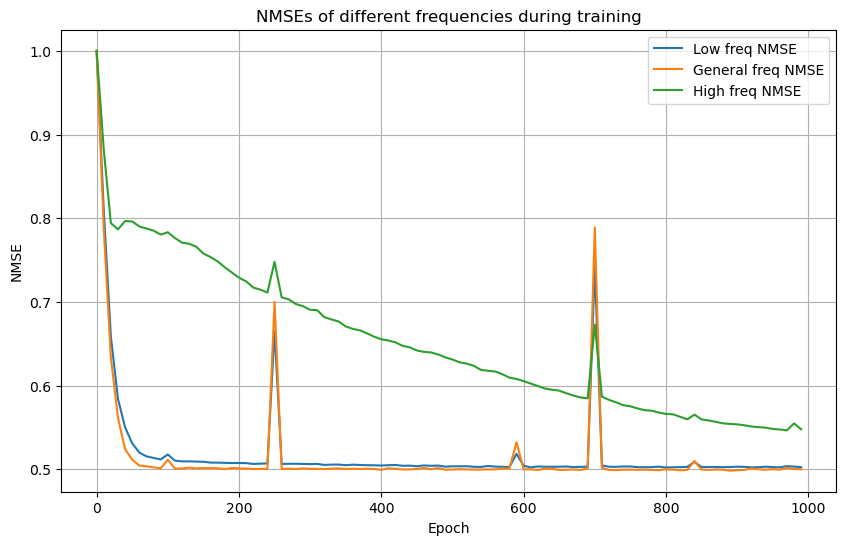

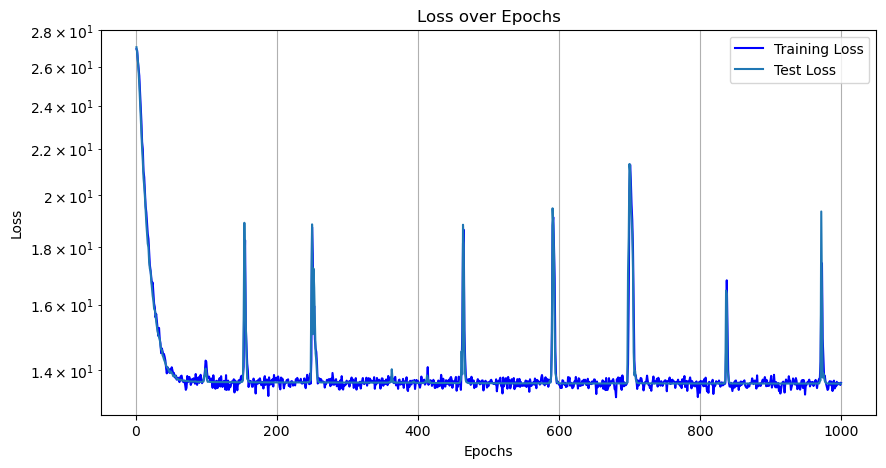

In [81]:
set_seed(seed)

L3Model = SimpleCNN(n_layers=3, kernel_size=3)
# model = L3Model

train_losses, test_losses = model_training(L3Model, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [85]:
print(f"MSE: {compute_mse(train_dataloader_g, L3Model)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_g, L3Model)[1]}")

print(f"MSE: {compute_mse(train_dataloader_h, L3Model)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_h, L3Model)[1]}")

MSE: 13.610291481018066
NMSE: 0.4992349445819855
MSE: 15267.4814453125
NMSE: 0.5455815196037292


**For kernel size 9**

Epoch [1/1000], Train Loss: 25.9184, Test Loss: 24.7014
Epoch [2/1000], Train Loss: 23.4723, Test Loss: 21.1390
Epoch [3/1000], Train Loss: 19.5074, Test Loss: 18.0734
Epoch [4/1000], Train Loss: 17.3020, Test Loss: 16.3570
Epoch [5/1000], Train Loss: 16.3410, Test Loss: 15.6571
Epoch [6/1000], Train Loss: 15.9736, Test Loss: 15.4081
Epoch [7/1000], Train Loss: 15.6993, Test Loss: 15.2246
Epoch [8/1000], Train Loss: 15.2573, Test Loss: 14.9974
Epoch [9/1000], Train Loss: 14.8945, Test Loss: 14.9864
Epoch [10/1000], Train Loss: 14.9615, Test Loss: 14.6792
Epoch [11/1000], Train Loss: 14.7207, Test Loss: 14.5793
Epoch [12/1000], Train Loss: 14.7234, Test Loss: 14.4417
Epoch [13/1000], Train Loss: 14.4501, Test Loss: 14.3361
Epoch [14/1000], Train Loss: 14.4165, Test Loss: 14.2581
Epoch [15/1000], Train Loss: 14.2150, Test Loss: 14.2097
Epoch [16/1000], Train Loss: 14.2988, Test Loss: 14.1145
Epoch [17/1000], Train Loss: 14.0958, Test Loss: 14.0637
Epoch [18/1000], Train Loss: 14.3440, Te

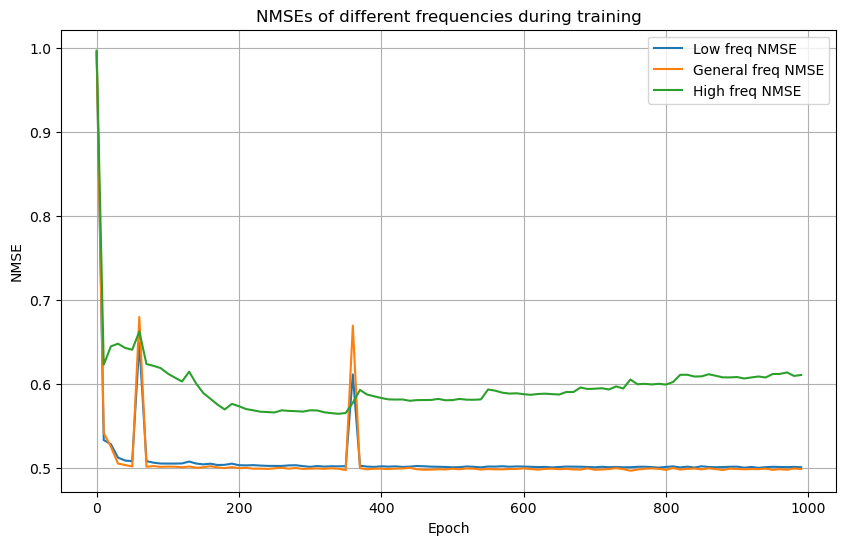

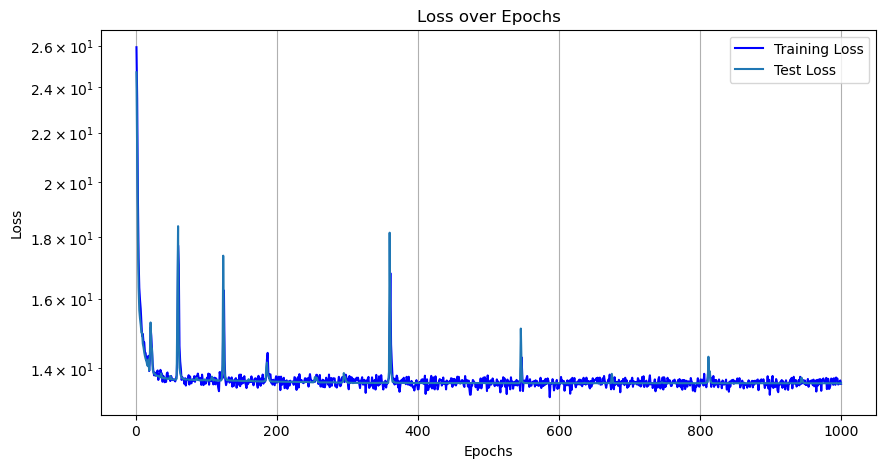

In [88]:
set_seed(seed)

L3ModelK10 = SimpleCNN(n_layers=3, kernel_size=9)
# model = L3Model

train_losses, test_losses = model_training(L3ModelK10, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [89]:
print(f"MSE: {compute_mse(train_dataloader_g, L3ModelK10)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_g, L3ModelK10)[1]}")

print(f"MSE: {compute_mse(train_dataloader_h, L3ModelK10)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_h, L3ModelK10)[1]}")

MSE: 13.615213394165039
NMSE: 0.4990744888782501
MSE: 17014.125
NMSE: 0.6086766123771667


**For kernel size 15**

Epoch [1/1000], Train Loss: 24.6033, Test Loss: 19.4132
Epoch [2/1000], Train Loss: 16.9388, Test Loss: 15.4413
Epoch [3/1000], Train Loss: 15.3317, Test Loss: 14.7203
Epoch [4/1000], Train Loss: 14.7265, Test Loss: 14.5423
Epoch [5/1000], Train Loss: 14.5383, Test Loss: 14.2931
Epoch [6/1000], Train Loss: 14.2042, Test Loss: 14.2216
Epoch [7/1000], Train Loss: 14.1698, Test Loss: 14.0551
Epoch [8/1000], Train Loss: 13.9966, Test Loss: 13.9906
Epoch [9/1000], Train Loss: 13.9003, Test Loss: 13.9648
Epoch [10/1000], Train Loss: 14.0602, Test Loss: 13.8835
Epoch [11/1000], Train Loss: 13.8920, Test Loss: 13.8608
Epoch [12/1000], Train Loss: 13.8630, Test Loss: 13.8253
Epoch [13/1000], Train Loss: 13.6765, Test Loss: 13.8207
Epoch [14/1000], Train Loss: 13.9970, Test Loss: 13.7839
Epoch [15/1000], Train Loss: 13.8914, Test Loss: 13.8004
Epoch [16/1000], Train Loss: 13.9077, Test Loss: 13.7702
Epoch [17/1000], Train Loss: 13.6681, Test Loss: 13.8027
Epoch [18/1000], Train Loss: 13.7196, Te

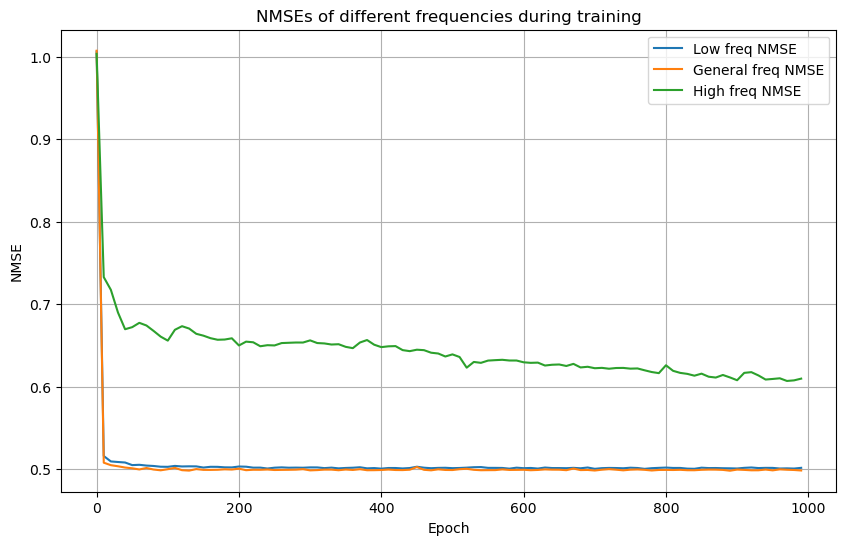

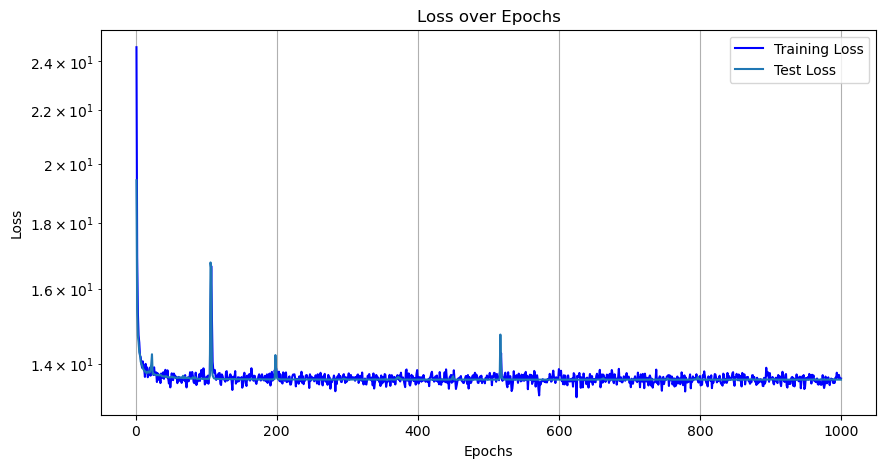

In [91]:
set_seed(seed)

L3ModelK10 = SimpleCNN(n_layers=3, kernel_size=15)
# model = L3Model

train_losses, test_losses = model_training(L3ModelK10, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [92]:
print(f"MSE: {compute_mse(train_dataloader_g, L3ModelK10)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_g, L3ModelK10)[1]}")

print(f"MSE: {compute_mse(train_dataloader_h, L3ModelK10)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_h, L3ModelK10)[1]}")

MSE: 13.68847942352295
NMSE: 0.498658150434494
MSE: 17023.638671875
NMSE: 0.6068426370620728


## Linear map

In [65]:
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        self.linear = nn.Linear(1000, 1000)

    def forward(self, x):
        return self.linear(x)

Epoch [1/1000], Train Loss: 8.0820, Test Loss: 1.8060
Epoch [2/1000], Train Loss: 2.0467, Test Loss: 0.5524
Epoch [3/1000], Train Loss: 0.4036, Test Loss: 0.3608
Epoch [4/1000], Train Loss: 0.1955, Test Loss: 0.0954
Epoch [5/1000], Train Loss: 0.0678, Test Loss: 0.0290
Epoch [6/1000], Train Loss: 0.0217, Test Loss: 0.0099
Epoch [7/1000], Train Loss: 0.0072, Test Loss: 0.0037
Epoch [8/1000], Train Loss: 0.0025, Test Loss: 0.0014
Epoch [9/1000], Train Loss: 0.0010, Test Loss: 0.0006
Epoch [10/1000], Train Loss: 0.0005, Test Loss: 0.0003
Epoch [11/1000], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [12/1000], Train Loss: 0.0002, Test Loss: 0.0001
Epoch [13/1000], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [14/1000], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [15/1000], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [16/1000], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [17/1000], Train Loss: 0.0001, Test Loss: 0.0000
Epoch [18/1000], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [19/1000], Tr

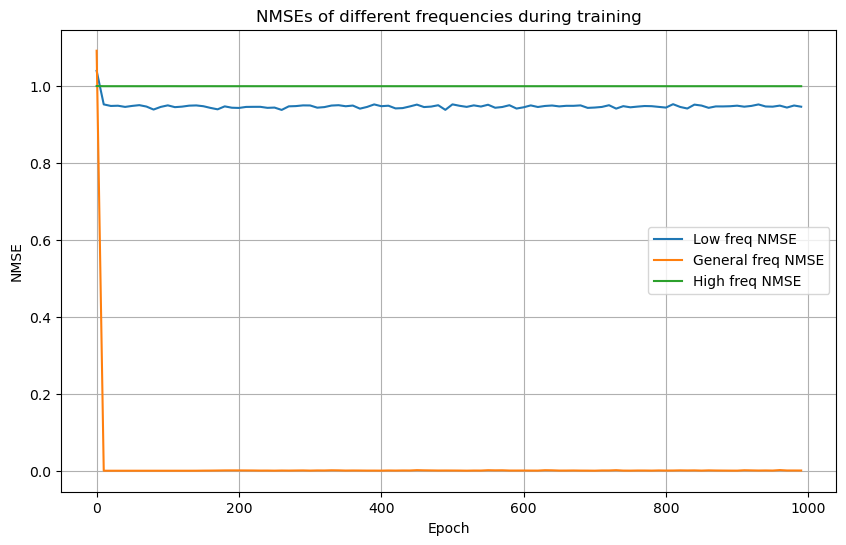

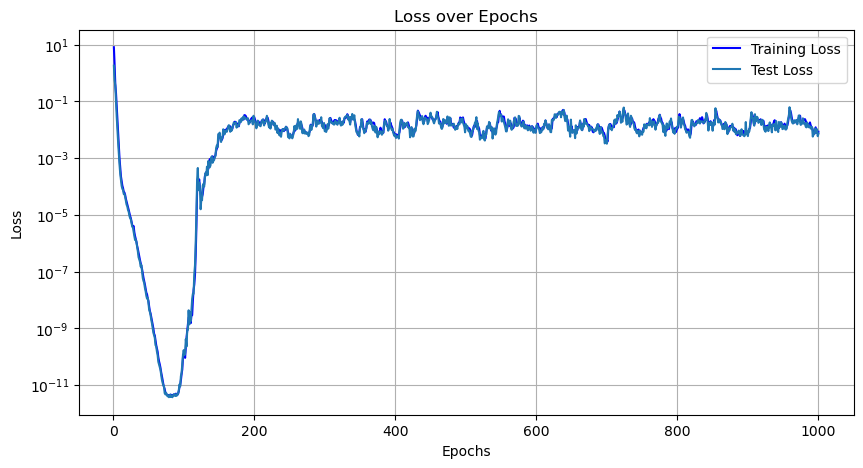

In [67]:
linearMap = SimpleLinear()

train_losses, test_losses = model_training(linearMap, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)